In this notebook, we will try to train a XGBoost model using permissions from 4287 benign and 3876 malicious android applications.

<h1>Loading Data</h1>

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [41]:
permissions_df = pd.read_csv('../catch-o-extractor/extracted_permissions.csv')
labeled_data_df = pd.read_csv('../catch-o-labeler/labeled_data.csv')

permissions_df = permissions_df.drop(permissions_df.columns[1], axis=1)
permissions_df = permissions_df.rename(columns={permissions_df.columns[0]: 'name'})

In [42]:
df = permissions_df.merge(labeled_data_df, left_on='name', right_on='hash', how='left')

df['detection'] = df['detection'].fillna('benign')

df = df.drop(columns=['hash'])


In [43]:
# Remove rows where detection is 'ransomware'
df = df[df['detection'] != 'ransomware']
# XGB does not combine well with classes that have a few samples.
df['detection'].value_counts()

detection
benign      4298
trojan      3179
adware       325
other        240
spyware       66
exploit       32
rootkit       11
hacktool       8
Name: count, dtype: int64

In [44]:
# Separate features and labels
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [45]:
# Encode string labels into numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



<h1>Training the XGBoost Classifier</h1>

In [46]:
# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

# Generate predictions
y_pred = xgb_clf.predict(X_test)

/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:51:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [47]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      adware       0.46      0.28      0.35        67
      benign       0.97      0.99      0.98       852
     exploit       0.75      0.43      0.55         7
    hacktool       0.00      0.00      0.00         1
       other       0.18      0.11      0.14        45
     rootkit       0.00      0.00      0.00         2
     spyware       0.56      0.38      0.45        13
      trojan       0.88      0.92      0.90       645

    accuracy                           0.90      1632
   macro avg       0.47      0.39      0.42      1632
weighted avg       0.88      0.90      0.89      1632



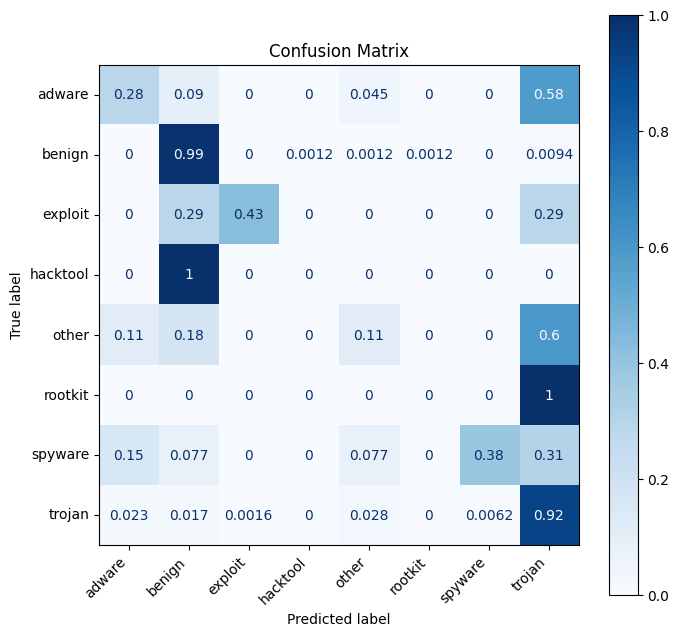

In [48]:
# Create confusion matrix display
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp = ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test, display_labels=label_encoder.classes_, cmap=plt.cm.Blues, normalize='true', ax=ax)

# Adjust label positions
plt.xticks(rotation=45, ha='right')
plt.yticks(va='center')

# Add some padding between the plot and the labels
plt.subplots_adjust(bottom=0.3, left=0.3)

plt.title("Confusion Matrix")
plt.show()

In [49]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Generate predicted probabilities
y_pred_proba = xgb_clf.predict_proba(X_test)

# Binarize the output
classes = label_encoder.classes_
y_test_bin = label_binarize(y_test, classes=range(len(classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


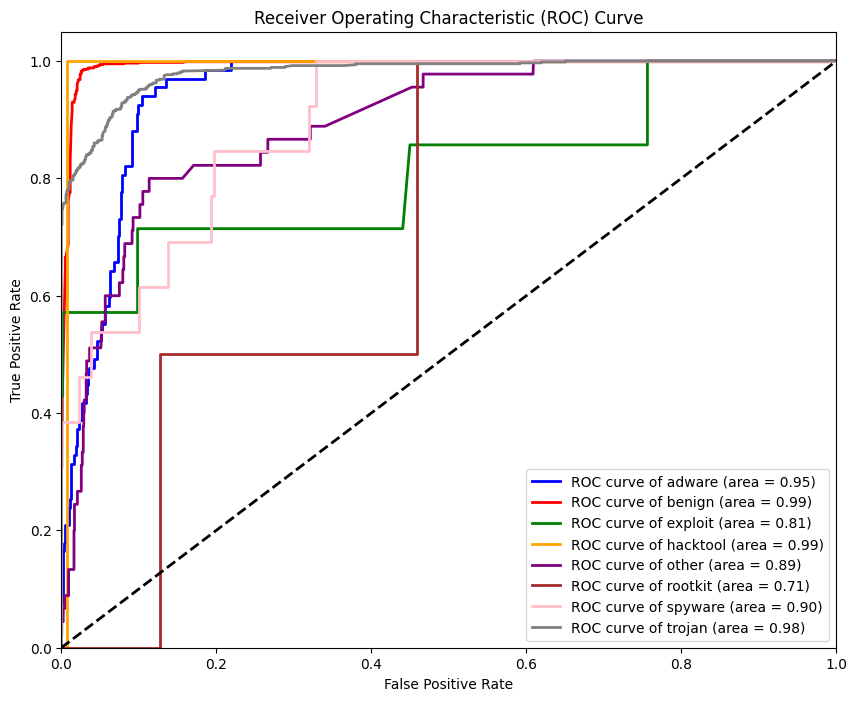

In [50]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
for i, color, cls in zip(range(len(classes)), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {cls} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


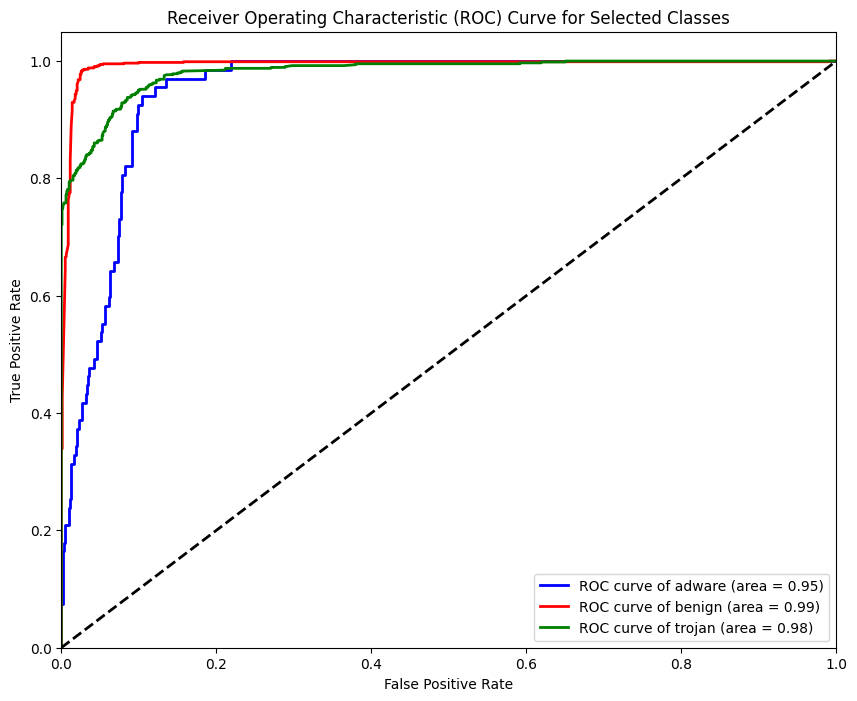

In [51]:
# Plot ROC curves for selected classes
selected_classes = ['adware', 'benign', 'trojan']  # Example of selected classes
colors = ['blue', 'red', 'green']
plt.figure(figsize=(10, 8))
for i, cls in enumerate(selected_classes):
    idx = list(label_encoder.classes_).index(cls)
    plt.plot(fpr[idx], tpr[idx], color=colors[i], lw=2, label=f'ROC curve of {cls} (area = {roc_auc[idx]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Selected Classes')
plt.legend(loc="lower right")
plt.show()


In [52]:
from sklearn.metrics import hamming_loss, balanced_accuracy_score, cohen_kappa_score

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)

# Hamming Loss
hamming = hamming_loss(y_test, y_pred)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Cohen's Kappa: {kappa}")
print(f"Hamming Loss: {hamming}")
print(f"Balanced Accuracy: {balanced_acc}")

Cohen's Kappa: 0.8203467369568432
Hamming Loss: 0.09987745098039216
Balanced Accuracy: 0.3898750279350044
